In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import itertools
from collections import Counter
import polars as pl
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

## Data Loading

In [3]:
df = pl.read_csv("data/ecoevo_jobs.csv", try_parse_dates=True)
df_us = pl.read_csv("data/ecoevo_jobs_us_tt.csv", try_parse_dates=True)

In [4]:
df_us.head()

season,timestamp,institution,location,subject_area,review_date,url,rank,appointment,is_r1
str,datetime[μs],str,str,str,date,str,str,str,bool
"""2020-2021""",2020-05-23 17:21:14.161,"""University of Wyoming""","""Wyoming""","""Plant Evolutionary Biology""",2020-09-01,"""https://uwyo.taleo.net/careers…","""Rank Open""","""Tenure Track""",false
"""2020-2021""",2020-06-23 15:48:04.414,"""Northwestern Oklahoma State Un…","""Oklahoma""","""Biology / Zoology""",null,"""https://www.higheredjobs.com/d…","""Asst Prof""","""Tenure Track""",false
"""2020-2021""",2020-06-30 17:49:25.263,"""Hope College""","""Michigan""","""Ecology""",2020-10-09,"""https://www.schooljobs.com/car…","""Asst Prof""","""Tenure Track""",false
"""2020-2021""",2020-07-01 17:26:18.853,"""University of South Alabama""","""Alabama""","""Plant Systematics""",2020-08-15,"""https://www.southalabama.edu/d…","""Asst Prof""","""Tenure Track""",false
"""2020-2021""",2020-07-01 17:29:02.514,"""University of South Alabama""","""Alabama""","""Development & Evolution""",2020-08-15,"""https://www.southalabama.edu/d…","""Asst Prof""","""Tenure Track""",false


## Figures

In [5]:
def add_rolling_count(df):
    """Note that this must be done *after* filtering!"""
    season = df['season'].to_list()
    assert len(set(season)) == 1
    season = season[0]
    start_year, end_year = tuple(map(int, season.split('-')))    
    return (df
            .with_columns(
              day_of_season = (pl.col('timestamp') - pl.date(month=1, day=1, year=start_year)).dt.total_days(),
              running_count = pl.arange(1, df.height + 1)
          ))

In [6]:
# Colors for figure
colors = {'2020-2021':'#9467bd',
          '2021-2022':'#d62728',
          '2022-2023':'#2ca02c',
          '2023-2024':'#ff7f0e',
          '2024-2025':'#1f77b4'}

# Grid settings
grid_params = dict(alpha=0.4, linestyle='dashed')

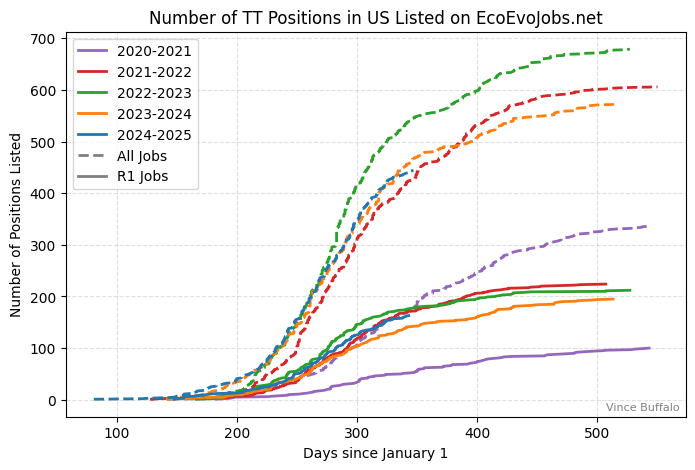

In [14]:
fig, ax = plt.subplots(figsize=(8, 5))

# First plot all the lines without labels
for (season, dfy) in df_us.group_by('season', maintain_order=True):
    color = colors[season[0]]
    df_r1 = dfy.filter(pl.col('is_r1'))
    df_r1 = add_rolling_count(df_r1)    
    ax.plot(df_r1['day_of_season'], df_r1['running_count'], color=color, linewidth=2)
    
    dfy_all = add_rolling_count(dfy)
    ax.plot(dfy_all['day_of_season'], dfy_all['running_count'], color=color, linewidth=2, linestyle='dashed')

# Add years to legend
for season in sorted(df_us['season'].unique()):
    color = colors[season]
    ax.plot([], [], color=color, label=season, linewidth=2)

# Add the line style indicators using grey color
ax.plot([], [], color='grey', linewidth=2, label='All Jobs', linestyle='dashed')
ax.plot([], [], color='grey', linewidth=2, label='R1 Jobs')

ax.set_title("Number of TT Positions in US Listed on EcoEvoJobs.net")
ax.set_ylabel('Number of Positions Listed')
ax.set_xlabel('Days since January 1')
ax.legend(frameon=True)
ax.grid(**grid_params)
ax.text(0.99, 0.01, 'Vince Buffalo', 
        transform=ax.transAxes,
        ha='right',
        va='bottom',
        alpha=0.5,
        fontsize=8)
fig.savefig("figures/evoevojobs.pdf")
fig.savefig("figures/evoevojobs.png")

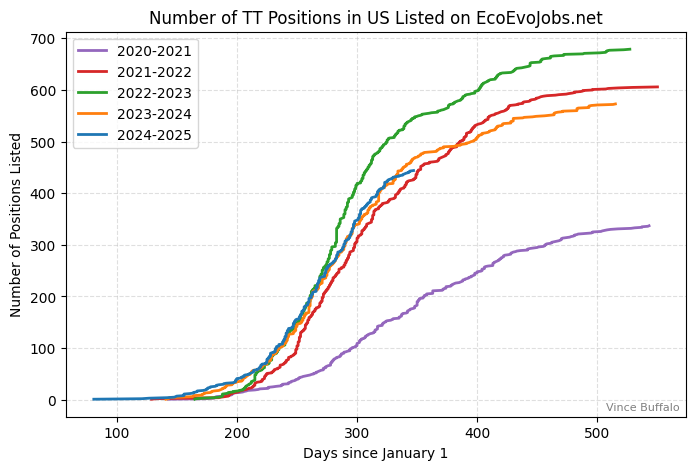

In [8]:
fig, ax = plt.subplots(figsize=(8, 5))

for (season, dfy) in df_us.group_by('season', maintain_order=True):
    color = colors[season[0]]
    dfy = add_rolling_count(dfy)
    ax.plot(dfy['day_of_season'], dfy['running_count'], label=season, color=color, linewidth=2)

ax.set_title("Number of TT Positions in US Listed on EcoEvoJobs.net")
ax.set_ylabel('Number of Positions Listed')
ax.set_xlabel('Days since January 1')
ax.legend(frameon=True)
ax.grid(**grid_params)

ax.text(0.99, 0.01, 'Vince Buffalo', 
        transform=ax.transAxes,
        ha='right',
        va='bottom',
        alpha=0.5,
        fontsize=8)

fig.savefig("figures/evoevojobs_all.pdf")
fig.savefig("figures/evoevojobs_all.png")

In [9]:
df.select('subject_area').unique().write_csv('data/all_subject_areas.csv')

In [10]:
evol_gen_fields = list(set([
   "Evolutionary Biology",
   "Genetics",
   "Evolutionary Genetics", 
   "Human Genetics",
   "Population Genetics",
   "Conservation Genetics",
   "Evolutionary Genomics",
   "Molecular Evolution",
   "Evolution",
   "Genetics/Genomics",
   "Evolutionary Developmental Biology", 
   "Molecular Genetics",
   "Population Genomics",
   "Evolution and Genetics",
   "Evolutionary Physiology",
   "Evolutionary Genetics & Genomics",
   "Evolutionary Geneticist",
   "Population Genetics with AI",
   "Population Genetics / Genomics and Biostatistics", 
   "Quantitative Genetics",
   "Molecular Evolutionary Biologist",
   "Plant Quantitative Genetics",
   "Statistical Geneticist",
   "Molecular Evolution or Genome Informatics",
   "Population Genetics or Genomics",
   "Evolutionary Genomics of Vertebrates",
   "Evolutionary & Global Change Genetics",
   "Human Evolutionary Genetics",
   "Molecular Genetics of Weeds and Invasive Species",
   "Evolutionary Genetics (Genomics of Speciation & Adaptation)",
   "Conservation Genetics / Genomics",
   "Evolutionary Functional Genomics",
   "Molecular Genetics of Adaptation",
   "Comparative Mammalian Genetics",
   "Population Genetics and Molecular Biogeography",
   "Evolutionary Networks"
]))

evol_gen_fields = [field.lower() for field in evol_gen_fields]

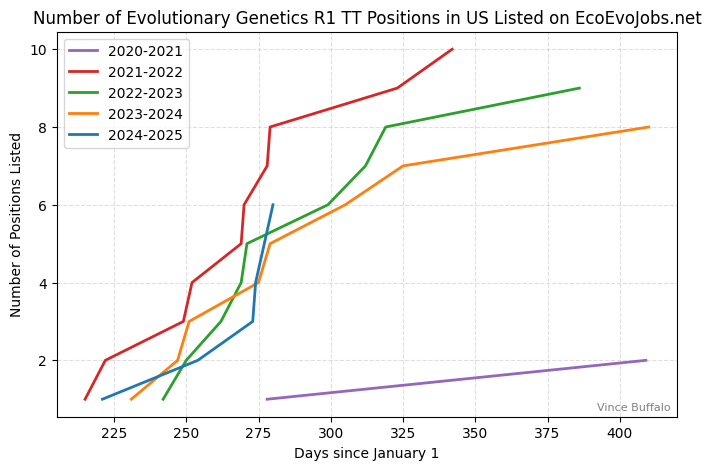

In [11]:
fig, ax = plt.subplots(figsize=(8, 5))

for (season, dfy) in df_us.group_by('season', maintain_order=True):
    color = colors[season[0]]
    dfy = dfy.filter(pl.col('subject_area').str.to_lowercase().is_in(evol_gen_fields), pl.col('is_r1'))
    dfy = add_rolling_count(dfy)
    ax.plot(dfy['day_of_season'], dfy['running_count'], label=season, color=color, linewidth=2)

ax.set_title("Number of Evolutionary Genetics R1 TT Positions in US Listed on EcoEvoJobs.net")
ax.set_ylabel('Number of Positions Listed')
ax.set_xlabel('Days since January 1')
ax.legend(frameon=True)
ax.grid(**grid_params)

ax.text(0.99, 0.01, 'Vince Buffalo', 
        transform=ax.transAxes,
        ha='right',
        va='bottom',
        alpha=0.5,
        fontsize=8)

fig.savefig("figures/evoevojobs_evolgen.pdf")
fig.savefig("figures/evoevojobs_evolgen.png")